## LG AI 해커톤, 블럭 장난감 제조 공정 최적화 AI경진대회

## 1. 라이브러리 및 데이터
## Library & Data

In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
from copy import deepcopy
import matplotlib.pyplot as plt
import os
import time
from module.genome import Genome, genome_score
warnings.filterwarnings(action='ignore')
np.random.seed(99) # 랜덤 시드 고정

# 필요 데이터 로드
path = 'module/'
order = pd.read_csv(path + 'order.csv')
stock = pd.read_csv(path + 'stock.csv')
max_count = pd.read_csv(path + 'max_count.csv')

## 2. 데이터 전처리
## Data Cleansing & Pre-Processing  

## 3. 탐색적 자료분석
## Exploratory Data Analysis

### 데이터 파일 확인

#### 1. order.csv
필요한 장난감 수요 확인

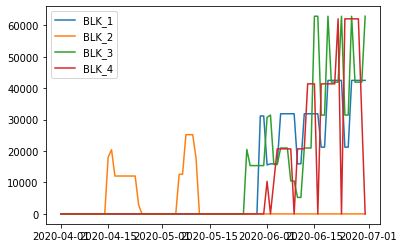

Order of BLK_1:  986353
Order of BLK_2:  244424
Order of BLK_3:  1103274
Order of BLK_4:  921032


In [2]:
order = pd.read_csv(path + 'order.csv')
time = pd.to_datetime(order['time'])

plt.figure()
plt.plot(time, order.loc[:,'BLK_1':'BLK_4'])
plt.legend(order.columns[1:])
plt.show()

print('Order of BLK_1: ',order['BLK_1'].sum())
print('Order of BLK_2: ',order['BLK_2'].sum())
print('Order of BLK_3: ',order['BLK_3'].sum())
print('Order of BLK_4: ',order['BLK_4'].sum())

BLK_2는 초반에, 나머지는 후반부에 필요하고 BLK_2는 다른 제품에 비해 수요가 적음

#### 2. max_count.csv
일별 최대 생산량 확인

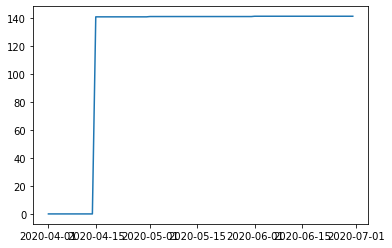

In [3]:
plt.figure()
plt.plot(time, max_count['count'])
plt.show()

4월 14일 이후부터 생산이 가능

#### 3. stock.csv
장난감 재고 확인

In [4]:
stock.head()

,PRT_1,PRT_2,PRT_3,PRT_4,MOL_1,MOL_2,MOL_3,MOL_4,BLK_1,BLK_2,BLK_3,BLK_4
0,0,258,0,0,1086,0,0,0,61158,87279,0,0


PRT의 초기 재고가 2번 장난감밖에 없기 때문에 초반 23일동안은 2번만 생산 가능

### global max score 예상

In [5]:
# 현재 재고로 생산 가능한 최대 제품 개수 확인 (불량품이 없다고 가정했을 때)
cut_ratio = np.array([506,506,400,400])
for i in [1, 2, 3, 4]:
    max_product = stock['PRT_'+str(i)] * cut_ratio[i-1] + stock['BLK_'+str(i)]
    print(f'maximum BLK of {i} is {max_product.values[0]}')

maximum BLK of 1 is 61158
maximum BLK of 2 is 217827
maximum BLK of 3 is 0
maximum BLK of 4 is 0


In [6]:
# 3개월동안 생산해야하는 대략적인 양 확인
need = np.zeros(4).astype(int)
for i in [1, 2, 3, 4]:
    max_product = stock['PRT_'+str(i)] * cut_ratio[i-1] + stock['BLK_'+str(i)]
    need[i-1] = order['BLK_' + str(i)].sum() -  max_product.values[0]
    print(f'Needed amount of BLK {i} is {need[i-1]}')

Needed amount of BLK 1 is 925195
Needed amount of BLK 2 is 26597
Needed amount of BLK 3 is 1103274
Needed amount of BLK 4 is 921032


BLK2번의 경우 거의 필요하지 않고 1,3,4 위주의 생산이 필요할 것이 예상됨

In [7]:
# Max count와 cut_yield를 고려한 대략적인 최대 생산량 확인, 2번 제품을 제외하고
print('필요한 수요의 총량: ',order.loc[:,['BLK_1','BLK_3','BLK_4']].values.sum())
print('23일 이후부터 생산 가능한 제품의 개수: ',(max_count.loc[23:,'count'].sum() * cut_ratio.min() * 0.7).astype(int)) # worst case

필요한 수요의 총량:  3010659
23일 이후부터 생산 가능한 제품의 개수:  2682305


2번 제품을 제외하고 생각해봤을 때 수요량보다 생산 가능한 제품의 개수가 적으므로,  
최적화를 통해 얻을 수 있는 score의 global maximum값은 100점보다 작을 것으로 예상됨

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

### 1. genome.py
3개의 class로 구성 (network, process, Genome)
+ network  
    mol 생산을 위한 event의 타입과 mol 개수 학습을 위한 네트워크
    method는 다음과 같음
        - init: weight 및 bias를 initialize. Xavier initialization를 이용
        - sigmoid, softmax, linear: activation function  
        - forward: forward pass, nonlinear activation function 전에 batch normalization 구현
+ process  
    mol 생산에 필요한 생산 라인이며 event_net과 mol_net을 포함  
    event는 check, process, change, stop 4종류  
    method는 다음과 같음
        - init: masking과 mol 생성에 필요한 변수 초기화 및 event_net과 mol_net 객체 생성
        - update_mask: 제약조건에 따라 event masking  
        - update: input 넣으면 event_net과 mol_net를 거쳐 output이 나오고 masking을 거쳐 event와 mol을 반환  
        - check_event, change_event: check와 change event가 일어날 시 masking에 필요한 변수를 update
        - progress_event: update에서 결정된 event와 mol을 통해 다음 시간대의 event를 masking 
        - initialize: masking에 필요한 변수 초기화
+ Genome  
    process 2개를 운영하는 객체이며 order가 들어왔을 때 Event_A, Mol_A, Event_B, Mol_B를 각각 결정  
    method는 다음과 같음  
        - init: 2개의 process 객체 생성  
        - predict: order를 입력으로 받아 2개의 process의 event, mol을 update  
            * 0일 ~ 20일: MOL생산에 초기 PRT 재고를 이용하므로 PRT가 있는 물품만 검사하도록 masking
            * mol이 6.66보다 크거나 max_count를 넘으면 생산량 조절
            * 0일 ~ 23일: MOL 생산량이 초기 PRT 재고보다 크면 생산량 조절

### 2. main.py

baseline 코드와 같이 event와 mol에 대해 neural net을 만들고 weight와 bias를 genetic algorithm으로 업데이트

#### 변수선택 및 initial guess

In [8]:
# 변수 선택
CPU_CORE = multiprocessing.cpu_count()          # 멀티프로세싱 CPU 사용 수
N_POPULATION = 31                               # 세대당 생성수
N_BEST = 9                                     # 베스트 수
N_CHILDREN = 3                                  # 자손 유전자 수
PROB_MUTATION = 0.10402353156771205            # 돌연변이
mutation_std = 0.7688261885970628               # 돌연변이시 standard deviation
REVERSE = True                                  # 배열 순서 (False: ascending order, True: descending order) == maximize
score_ini = 0                                   # 초기 점수
process_duration = 35                           # batch size
input_length = (process_duration) * 4 + 1       # neural net의 input length
output_length_1 = 18                            # Event length (CHECK_1~4, PROCESS)
resolution = 8                                  # mol 생산량의 resolution
output_length_2 = (int)(resolution * 6.6 + 2)   # MOL(0~6.6, step:0.1)
h1 = (26,26)                                    # 히든레이어1 노드 수 (event, mol)
h2 = (5,5)                                    # 히든레이어2 노드 수 (event, mol)
h3 = (18,18)                                    # 히든레이어3 노드 수 (event, mol)
EPOCHS = 1000                                   # 반복 횟수
early_stopping = 1000                           # saturation시 early stopping
crossover_fraction = 0.10380249184846946         # crossover 비율 
save_file_name = 'submit.csv'

# Initial guess
genomes = []
for _ in range(N_POPULATION):
    genome = Genome(score_ini, input_length, output_length_1, output_length_2, resolution, h1, h2, h3, process_duration, init_weight=None)
    genomes.append(genome)
try:
    for i in range(N_BEST):
        genomes[i] = best_genomes[i]
except:
    best_genomes = []
    for _ in range(N_BEST): # genome의 개수 여기서 조정
        genome = Genome(score_ini, input_length, output_length_1, output_length_2, resolution, h1, h2, h3, process_duration,init_weight=None)
        best_genomes.append(genome)
print('==Process 1 Done==')

==Process 1 Done==


#### crossover 및 mutation method

In [9]:
def crossover(process_1, process_2, new_process, weight, crossover_fraction):
    # crossover event
    for j in range(getattr(new_process.event_net, weight).shape[0]):
        w_e = getattr(new_process.event_net, weight).shape[1]
        cut = np.zeros(w_e)
        cut[np.random.choice(range(w_e), (int)(np.floor(w_e * crossover_fraction)))] = 1
        getattr(new_process.event_net, weight)[j, cut == 1] = getattr(process_1.event_net, weight)[j, cut == 1]
        getattr(new_process.event_net, weight)[j, cut == 0] = getattr(process_2.event_net, weight)[j, cut == 0]
    # crossover mol
    for j in range(getattr(new_process.mol_net, weight).shape[0]):
        w_m = getattr(new_process.mol_net, weight).shape[1]
        cut = np.zeros(w_m)
        cut[np.random.choice(range(w_m), (int)(np.floor(w_m * crossover_fraction)))] = 1
        # crossover event
        getattr(new_process.mol_net, weight)[j, cut == 1] = getattr(process_1.mol_net, weight)[j, cut == 1]
        getattr(new_process.mol_net, weight)[j, cut == 0] = getattr(process_2.mol_net, weight)[j, cut == 0]
    return new_process

def mutation(new_process, mean, stddev, weight):
    # mutation event
    w_e = getattr(new_process.event_net, weight).shape[0]
    h_e = getattr(new_process.event_net, weight).shape[1]
    if np.random.uniform(0, 1) < PROB_MUTATION:
        new_process.event_net.__dict__[weight] = new_process.event_net.__dict__[weight] * np.random.normal(mean, stddev, size=(w_e, h_e)) * np.random.randint(0, 2, (w_e, h_e))
    # mutation mol
    w_m = getattr(new_process.mol_net, weight).shape[0]
    h_m = getattr(new_process.mol_net, weight).shape[1]
    if np.random.uniform(0, 1) < PROB_MUTATION:
        new_process.mol_net.__dict__[weight] = new_process.mol_net.__dict__[weight] * np.random.normal(mean, stddev, size=(w_m, h_m)) * np.random.randint(0, 2, (w_m, h_m))
    return new_process

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation

최적화 문제이므로 별도의 검증이 필요 없다 생각하여 학습만 진행

#### 모델 학습

In [10]:
import time
start = time.time()
n_gen = 1 
score_history = []
high_score_history = []
mean_score_history = []
while n_gen <= EPOCHS:
    genomes = np.array(genomes)    
    while len(genomes)%CPU_CORE != 0:
        genomes = np.append(genomes, Genome(score_ini, input_length, output_length_1, output_length_2,resolution, h1, h2, h3, process_duration,init_weight=None))
    genomes = genomes.reshape((len(genomes)//CPU_CORE, CPU_CORE))
    
    for idx, _genomes in enumerate(genomes):
        if __name__ == '__main__':
            pool = multiprocessing.Pool(processes=CPU_CORE)
            genomes[idx] = pool.map(genome_score, _genomes)
            pool.close()
            pool.join()
    genomes = list(genomes.reshape(genomes.shape[0]*genomes.shape[1]))    
    
     # score에 따라 정렬
    genomes.sort(key=lambda x: x.score, reverse=REVERSE)
    
    # 평균 점수
    s = 0 
    for i in range(N_BEST):
        s += genomes[i].score
    s /= N_BEST
    
    # Best Score
    bs = genomes[0].score 
    
    # Best Model 추가
    if best_genomes is not None:
        genomes.extend(best_genomes)
        
    # score에 따라 정렬
    genomes.sort(key=lambda x: x.score, reverse=REVERSE)
    
    score_history.append([n_gen, genomes[0].score])
    high_score_history.append([n_gen, bs])
    mean_score_history.append([n_gen, s])
    
    # 결과 출력
    if n_gen%10 == 0:
        print('EPOCH #%s\tHistory Best Score: %s\tBest Score: %s\tMean Score: %s' % (n_gen, genomes[0].score, bs, s))    
    
    # 모델 업데이트
    best_genomes = deepcopy(genomes[:N_BEST])

    # CHILDREN 생성 -- 부모로부터 crossover을 해서 children 생성
    for i in range(N_CHILDREN):
        new_genome = deepcopy(best_genomes[0])
        genome_1 = np.random.choice(best_genomes)
        genome_2 = np.random.choice(best_genomes)

        for weight in ['w1','w2','w3','w4','b1','b2','b3','b4']:
            new_genome.process_1.__dict__[weight] = crossover(genome_1.process_1, genome_2.process_1, new_genome.process_1, weight, crossover_fraction)
            new_genome.process_2.__dict__[weight] = crossover(genome_1.process_2, genome_2.process_2, new_genome.process_2, weight, crossover_fraction)
    
    # 모델 초기화
    genomes = []
    for i in range(int(N_POPULATION / len(best_genomes))):
        for bg in best_genomes:
            new_genome = deepcopy(bg)            
            mean = 0
            stddev = mutation_std
            # Mutation
            for weight in ['w1','w2','w3','w4','b1','b2','b3','b4']:
                new_genome.process_1.__dict__[weight] = mutation(new_genome.process_1, mean, stddev, weight)
                new_genome.process_2.__dict__[weight] = mutation(new_genome.process_2, mean, stddev, weight)
            genomes.append(new_genome)
            
    if REVERSE:
        if bs < score_ini:
            genomes[len(genomes)//2:] = [Genome(score_ini, input_length, output_length_1, output_length_2,resolution, h1, h2, h3, process_duration,init_weight=None) for _ in range(N_POPULATION//2)]
    else:
        if bs > score_ini:
            genomes[len(genomes)//2:] = [Genome(score_ini, input_length, output_length_1, output_length_2,resolution, h1, h2, h3, process_duration,init_weight=None) for _ in range(N_POPULATION//2)]

    # early stopping
    if n_gen > early_stopping:
        last_scores = high_score_history[-1 * early_stopping:]
        sub_scores = list(map(lambda x: x[1], last_scores))
        if np.argmax(sub_scores) == 0:
            print('No improvement, early stopping...')
            break

    n_gen += 1

print('==Process 2 Done==')
print(f'Time for Train model is {time.time() - start} second')

EPOCH #10	History Best Score: 82.34092494722869	Best Score: 82.34092494722869	Mean Score: 80.2117436478975
EPOCH #20	History Best Score: 85.5852667965763	Best Score: 85.5852667965763	Mean Score: 84.42473987777134
EPOCH #30	History Best Score: 85.75779665218982	Best Score: 85.5852667965763	Mean Score: 83.80790696918672
EPOCH #40	History Best Score: 87.04376447543734	Best Score: 87.04376447543734	Mean Score: 86.16085522584558
EPOCH #50	History Best Score: 87.65352342782043	Best Score: 87.65352342782043	Mean Score: 86.70946084716148
EPOCH #60	History Best Score: 88.28080697174235	Best Score: 88.28080697174235	Mean Score: 87.58212217829576
EPOCH #70	History Best Score: 88.50642333851395	Best Score: 88.50642333851395	Mean Score: 86.33173797048696
EPOCH #80	History Best Score: 88.50642333851395	Best Score: 88.50642333851395	Mean Score: 87.6399875722575
EPOCH #90	History Best Score: 88.53779488879394	Best Score: 88.53779488879394	Mean Score: 87.42378014801945
EPOCH #100	History Best Score: 88

EPOCH #770	History Best Score: 91.3384027381176	Best Score: 91.3384027381176	Mean Score: 90.65196927731523
EPOCH #780	History Best Score: 91.3384027381176	Best Score: 91.3384027381176	Mean Score: 91.04649592993822
EPOCH #790	History Best Score: 91.3384027381176	Best Score: 91.3384027381176	Mean Score: 89.31387713035616
EPOCH #800	History Best Score: 91.3384027381176	Best Score: 91.3384027381176	Mean Score: 91.05740410032895
EPOCH #810	History Best Score: 91.3384027381176	Best Score: 91.3384027381176	Mean Score: 91.33840273811758
EPOCH #820	History Best Score: 91.3384027381176	Best Score: 91.3384027381176	Mean Score: 91.33840273811758
EPOCH #830	History Best Score: 91.3384027381176	Best Score: 91.3384027381176	Mean Score: 90.87766654320164
EPOCH #840	History Best Score: 91.3384027381176	Best Score: 91.3384027381176	Mean Score: 86.78266588369587
EPOCH #850	History Best Score: 91.3384027381176	Best Score: 91.3384027381176	Mean Score: 90.74499906078518
EPOCH #860	History Best Score: 91.338

## 6. 결과 및 결언
## Conclusion & Discussion

#### 결과 그래프

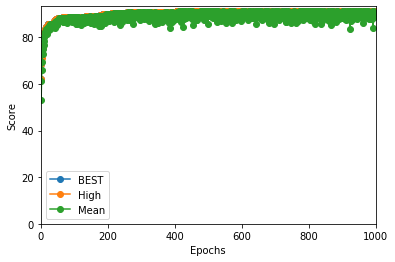

In [15]:
# Score Graph
score_history = np.array(score_history)
high_score_history = np.array(high_score_history)
mean_score_history = np.array(mean_score_history)

plt.plot(score_history[:,0], score_history[:,1], '-o', label='BEST')
plt.plot(high_score_history[:,0], high_score_history[:,1], '-o', label='High')
plt.plot(mean_score_history[:,0], mean_score_history[:,1], '-o', label='Mean')
plt.legend()
plt.xlim(0, EPOCHS)
plt.ylim(bottom=0)
plt.xlabel('Epochs')
plt.ylabel('Score')

plt.show()

#### submission 파일의 재고와 수요 그래프

In [16]:
from module.simulator_explain import Simulator
simulator = Simulator()
submission = best_genomes[0].submission
df = simulator.subprocess(submission)
out_1 = simulator.cal_schedule_part_1(df)
out_2 = simulator.cal_schedule_part_2(df, line='A')
out_3 = simulator.cal_schedule_part_2(df, line='B')
out = out_1 + out_2 + out_3
out = simulator.add_stock(out, simulator.stock)
order_submission = simulator.order_rescale(out, simulator.order)
out, blk_diffs = simulator.cal_stock(out, order_submission)

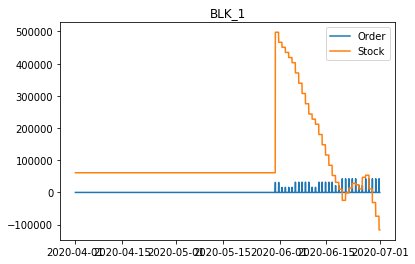

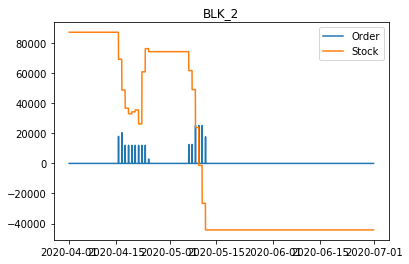

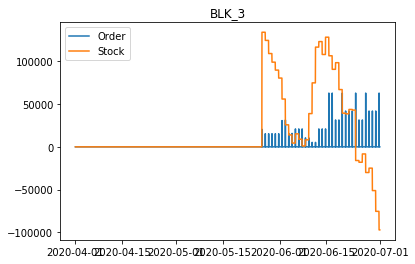

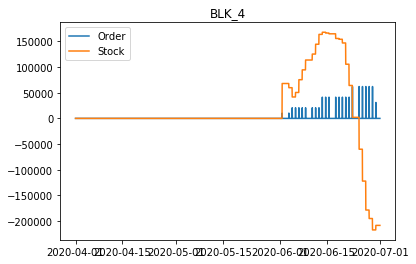

In [17]:
for column in ['BLK_1','BLK_2','BLK_3','BLK_4']:
    plt.figure()
    plt.plot(order_submission[column])
    plt.plot(out[column])
    plt.title(column)
    plt.legend(['Order','Stock'])
    plt.show()

+ 전체적으로 수요가 발생한 시점에는 과다하게 생산하고 뒤로 갈수록 부족분이 많아짐

#### submission 파일 제출

In [21]:
from module.simulator import Simulator
simulator = Simulator()
import time
start = time.time()
score = simulator.get_score(submission)

# PRT 개수 계산 -- MOL을 바탕으로
PRTs = out[['PRT_1', 'PRT_2', 'PRT_3', 'PRT_4']].values
PRTs = (PRTs[:-1] - PRTs[1:])[24*23:]          
PRTs = np.ceil(PRTs * 1.1)                     
PAD = np.zeros((24*23+1, 4))                   
PRTs = np.append(PRTs, PAD, axis=0).astype(int)

# Submission 파일에 PRT 입력
submission.loc[:, 'PRT_1':'PRT_4'] = PRTs
submission.to_csv(save_file_name, index=False)
print(f'Time for Test model is {time.time() - start } second')

Time for Test model is 0.2615501880645752 second
